In [2]:
%matplotlib inline
import matplotlib as mplt 
from matplotlib import cm 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib 
from matplotlib.ticker import FuncFormatter 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import statsmodels as sm 
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf 
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.stats import diagnostic

from utils_libs import *
from utils_data_prep import * 

from mixture import *

In [4]:
# ---- set-up ----

# ---- MAE
def eval_mae(df):
    
    diff = df['truth'] - df['pre']
    return mean( abs(diff) )


# ---- MAPE
def eval_mape(df):
    
    diff = df['truth'] - df['pre']
#   ?
    tmp = abs(diff/(df['truth']+1e-10))

    tmpsum = []
    for i in range(len(tmp)):
        if abs(df['truth'].iloc[i])>1e-5:
            tmpsum.append( tmp[i] )
                    
    return mean(tmpsum)

# ---- RMSE
def eval_rmse(df):
    return sqrt(mean((df['truth']-df['pre'])**2))
    
# ---- ACCURACY
col_format_mix = ['truth', 'pre', 'pre_v', 'pre_b']
col_format_gate = ['vol', 'ob']
col_format = ['truth', 'pre']

features_ob = [ 'spread', 'weightd spread', 'ask vol.', 'bid vol.', 'vol. diff.', 'ask depth', 'bid depth', \
               'depth diff.', 'bid slope', 'ask slope']

models = ['gbt', 'rf', 'xgt', 'gp', 'bayes', 'enet', 'ridge']
# 'arima', arimax', 'lasso', 'str', 'strx', 'garch', 'egarch'

file_path = "../bt_results/res/rolling/"

pre_ts = 'pytest_'
pre_tr = 'pytrain_'

gate_ts = 'gate_test'
gate_tr = 'gate_train'

post_txt = '.txt'
post_dat = '.dat'

weight_pre = '_weight_pre'
weight_gate = '_weight_gate'

bin_bound = []
for i in range(50):
    bin_bound.append(i*0.02)

    
#  Mean	Absolute	Error	(MAE):
#  Mean	Relative	Error	(MRE)	


# ---- Significance test

# Paired data: Wilcoxon signed-rank test, paired Student's t-test 

# Sample data: ks-test, sample mean test

In [5]:
# PLOT prediction and truth 
for i in range(2,14):
    
    # plot
    fig, ax = plt.subplots(2, 4, figsize=(19,8))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    ax[0][0].plot(df['truth'], label = 'truth')
    ax[0][0].plot(df['pre'], label = 'mixture pre')
    ax[0][0].legend()
    ax[0][0].set_ylim([0,1])
    
    k = 0
    for k in range(1, 4):
        tmp_mdl = models[k-1]
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        ax[0][k].plot(df['truth'], label = 'truth')
        ax[0][k].plot(df['pre'], label = tmp_mdl + ' pre')
        ax[0][k].legend()
        ax[0][k].set_ylim([0,1])
        
        
    for k in range( 4):
        tmp_mdl = models[k+3]
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        ax[1][k].plot(df['truth'], label = 'truth')
        ax[1][k].plot(df['pre'], label = tmp_mdl + ' pre')
        ax[1][k].legend()
        ax[1][k].set_ylim([0,1])
        
        
    fig.savefig('../bt_results/res/pics/pre_test_' + str(i-1) + '.jpeg', bbox_inches='tight')
    plt.close()

In [ ]:
# log normal statitiscal test
for i in range(2,14):
    
    print ' --- interval ', i-1, ': ' 
    
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
#     print 'mix', stats.kstest(np.asarray( df['truth']-df['pre'] ), 'norm')
#     print 'mix', stats.mstats.normaltest(np.asarray( df['truth']-df['pre'] ))
    
    print 'mix', sm.stats.diagnostic.acorr_ljungbox(np.asarray( df['truth']-df['pre']), \
                                                    lags = 5, boxpierce=False)[1]
    
#     print  i, ':', stats.ks_2samp( np.asarray(mix_res), np.asarray(tmp_res) )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_tr + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        print tmp_mdl, sm.stats.diagnostic.acorr_ljungbox(np.asarray( df['truth']-df['pre']), \
                                                        lags = 5, boxpierce=False)[1]

In [5]:
# statitiscal test
for i in range(2,14):
    
    print ' --- interval ', i-1, ': ' 
    
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
#     print 'mix', stats.kstest(np.asarray( df['truth']-df['pre'] ), 'norm')
#     print 'mix', stats.mstats.normaltest(np.asarray( df['truth']-df['pre'] ))
    
    print 'mix', sm.stats.diagnostic.acorr_ljungbox(np.asarray( df['truth']-df['pre']), \
                                                    lags = 5, boxpierce=False)[1]
    
#     print  i, ':', stats.ks_2samp( np.asarray(mix_res), np.asarray(tmp_res) )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_tr + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        print tmp_mdl, sm.stats.diagnostic.acorr_ljungbox(np.asarray( df['truth']-df['pre']), \
                                                        lags = 5, boxpierce=False)[1]
        
#         print tmp_mdl, stats.mstats.normaltest(np.asarray( df['truth']-df['pre'] ))
#         print tmp_mdl, stats.kstest(np.asarray( df['truth']-df['pre'] ), 'norm')

In [6]:
# Prediction errors 

print ' --- RMSE'
# RMSE
for i in range(2,14):
    
    tmp_rmse = []
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    tmp_rmse.append( eval_rmse(df) )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        tmp_rmse.append( eval_rmse(df) )
        
    print 'interval ', i-1, ': ', tmp_rmse
    

print '\n --- MAPE'
# MAPE
for i in range(2,14):
    
    tmp_rmse = []
    tmp_mape = []
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    tmp_mape.append( eval_mape(df) )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        tmp_mape.append( eval_mape(df) )
        
    print 'interval ', i-1, ': ', tmp_mape
    
    
print '\n --- MAE'
# MAPE
for i in range(2,14):
    
    tmp_rmse = []
    tmp_mape = []
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    tmp_mape.append( eval_mae(df) )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        tmp_mape.append( eval_mae(df) )
        
    print 'interval ', i-1, ': ', tmp_mape

    

 --- RMSE
interval  1 :  [0.073860859804400616, 0.088393956171109192, 0.078211463087352578, 0.083732267960057422, 0.087825280244581083, 0.08783687699442061, 0.078092453459051733, 0.083009415488212029]
interval  2 :  [0.059609428777097885, 0.064614483591748081, 0.060024253643625521, 0.059368972068381091, 0.063393061303392853, 0.065811029560769577, 0.058990643361074555, 0.061007591860943157]
interval  3 :  [0.043901464700490368, 0.048029502076402684, 0.045798185050094808, 0.045505068586124638, 0.047127068068155892, 0.047460971694223406, 0.046707556262830713, 0.047147063738557725]
interval  4 :  [0.10871351450917537, 0.11547183883520619, 0.12682473354671084, 0.11137653643301758, 0.11330439195792741, 0.11366155409123714, 0.1099800318613271, 0.10998003186132713]
interval  5 :  [0.057332344974085646, 0.063356698192017183, 0.061469125277998117, 0.059691761315813566, 0.083339027941627647, 0.058496711410308745, 0.059050614706894454, 0.058528552712739414]
interval  6 :  [0.075896829938404353, 0.

In [ ]:
# top-k features over intervals

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 

# features_ob = [ 'spread', 'weightd spread', 'ask vol.', 'bid vol.', 'vol. diff.', 'ask depth', 'bid depth', \
#                'depth diff.', 'bid slope', 'ask slope']

for i in range(2,14):
    
    print '-- interval ', i-1
    
    # DATA
    file_name = str(i) + weight_pre + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    
#     np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
#     np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    
    ft_weight = list(zip(features_ob, np.abs(np.squeeze(tmp_weight[3]))))
    
    tmp = sorted(ft_weight, key = lambda x: x[1], reverse = True)
    print tmp[:3]
    
    file_name = str(i) + weight_gate + post_dat
    tmp_weight = np.load(file_path + file_name)
    
#     np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
#     np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    
    ft_weight = list(zip(features_ob, np.abs(np.squeeze(tmp_weight[3]))))
    
    tmp = sorted(ft_weight, key = lambda x: x[1], reverse = True)
    print tmp[:3]
    
    print '\n'


In [ ]:
# parameter distribution of mixture expert

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 

vol_temp = []
ob_temp = []
ob_ft = []

for i in range(2,14):
    # DATA
    file_name = str(i) + weight_pre + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    vol_temp.append( np.flip(np.squeeze(tmp_weight[0]),0) )
    ob_temp.append( np.flip(np.squeeze(tmp_weight[2]),0) )
    ob_ft.append( np.squeeze(tmp_weight[3]) )
    
     # PLOT 
    fig, ax_list = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    ax_list[0].bar(range(len(np.squeeze(tmp_weight[0]))), np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
    ax_list[0].set_title('Auto-regressive volatility')
    ax_list[0].set(xlabel='Temporal lags', ylabel='weights')
    ax_list[0].set_ylim(0,0.2)
    
    ax_list[1].bar(range(len(np.squeeze(tmp_weight[2]))), np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    ax_list[1].set_title('Temporal dependency on order book')
    ax_list[1].set(xlabel='Temporal lags')
    ax_list[1].set_ylim(0,0.5)
    
    ax_list[2].bar( range(len(np.squeeze(tmp_weight[3])) ), np.abs(np.squeeze(tmp_weight[3])) )
    ax_list[2].set_title('Feature dependency on order book')
    tmp_ind = range(len(np.squeeze(tmp_weight[3])))
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    ax_list[2].set_ylim(0,0.15)
    
    plt.subplots_adjust(top=0.85)
    
print np.shape(vol_temp), np.shape(ob_temp), np.shape(ob_ft)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(vol_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_ft));

#    


In [ ]:
# parameter distribution of mixture gate

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 

vol_temp = []
ob_temp = []
ob_ft = []

for i in range(2,14):
    
    # DATA
    file_name = str(i) + weight_gate + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    vol_temp.append( np.flip(np.squeeze(tmp_weight[0]),0) )
    ob_temp.append( np.flip(np.squeeze(tmp_weight[2]),0) )
    ob_ft.append( np.squeeze(tmp_weight[3]) )
    
    # PLOT 
    fig, ax_list = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    ax_list[0].bar(range(len(np.squeeze(tmp_weight[0]))), np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
    ax_list[0].set_title('Auto-regressive volatility')
    ax_list[0].set(xlabel='Temporal lags', ylabel='weights')
    ax_list[0].set_ylim(0,0.5)
    
    ax_list[1].bar(range(len(np.squeeze(tmp_weight[2]))), np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    ax_list[1].set_title('Temporal dependency on order book')
    ax_list[1].set(xlabel='Temporal lags')
    ax_list[1].set_ylim(0,0.5)
    
    ax_list[2].bar( range(len(np.squeeze(tmp_weight[3])) ), np.abs(np.squeeze(tmp_weight[3])) )
    ax_list[2].set_title('Feature dependency on order book')
    tmp_ind = range(len(np.squeeze(tmp_weight[3])))
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    ax_list[2].set_ylim(0, 1.0)
    
    plt.subplots_adjust(top=0.85)
    
print np.shape(vol_temp), np.shape(ob_temp), np.shape(ob_ft)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(vol_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_ft));

#    


In [ ]:
# gate and volatility correlation

# TO DO: LOOK INTO THE FUTURE OF VOLATILITY

for i in range(2,14):
    
    # truth in training 
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    y_tr = list(df['truth'])
    
    # truth in testing
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    y_ts = list(df['truth'])
    
    # gates in training
    file_name = str(i) + '_' + gate_tr + post_txt
    df_tr = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    # gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_ts = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    # ?
    gate_ob = list(df_ts['ob'])
    up_idx = []
    for j in range(1, len(gate_ob)):
        if 1.0*(gate_ob[j]-gate_ob[j-1])/gate_ob[j-1] > 0.9:
            up_idx.append(j)
    cnt = 0
    for k in up_idx:
        # ?
        if k-1>=0 and y_ts[k]>y_ts[k-1]:
            cnt+=1
        
    print 1.0*cnt/len(up_idx)    
        
    

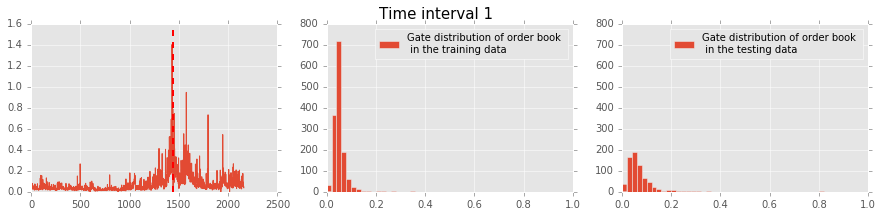

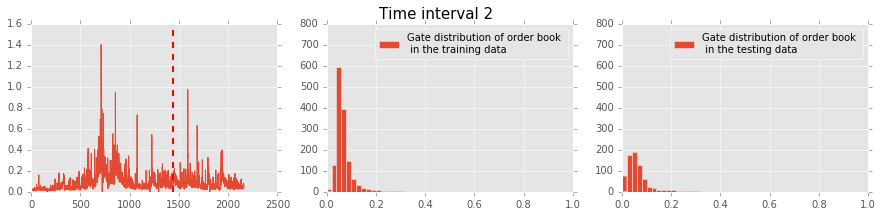

In [4]:
bin_bound = []
for i in range(50):
    bin_bound.append(i*0.02)

for i in range(2,4):
    
    # truth in training 
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    y_tr = list(df['truth'])
    
    # truth in testing
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    y_ts = list(df['truth'])
    
    # gates in training
    file_name = str(i) + '_' + gate_tr + post_txt
    df_tr = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    # gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_ts = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    # plot
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    ax[0].plot(y_tr + y_ts, label = 'Volatility series in training and testing set')
    ax[0].axvline( len(y_tr), color = 'r', linewidth = 2.0, linestyle = '--' )
    
    ax[1].hist(df_tr['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the training data ')
    ax[1].set_ylim(0,800)
    ax[1].legend(fontsize=10)
    
    ax[2].hist(df_ts['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the testing data')
    ax[2].set_ylim(0,800)
    ax[2].legend(fontsize=10)
#     ax.legend()
#     ax.set_ylim(0,350)
#     ax.set_xlim(0,1.0)
#     plt.axvline( len(y_tr), color = 'r', linewidth = 2.0, linestyle = '--' )
#     plt.title("Time interval " + str(i-1), fontsize = 15)
    
    
    

In [ ]:
# training data   hist, prediction, gate

bin_bound = []
for i in range(50):
    bin_bound.append(i*0.02)

for i in range(2, 14):
    
    # truth in training 
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # gates in training
    file_name = str(i) + '_' + gate_tr + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # plot
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    # hist
    ax[0].hist(df_gate['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the training data ')
    ax[0].set_ylim(0,800)
    ax[0].legend(fontsize=10)
    
    # truth and prediction
    ax[1].plot(df_pre['truth'], label = 'Truth')
    ax[1].plot(df_pre['pre'], label = 'Prediction')
    ax[1].plot(df_pre['pre_v'], label = 'Pre_v')
    ax[1].plot(df_pre['pre_b'], label = 'Pre_b')
    ax[1].legend()
    ax[1].set_ylim(0,3)
    
    # gate distribution
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[2].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[2].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[2].plot(Y2,)
    ax[2].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[2].fill_between(X, Y1,Y2, color='y',alpha=.5)
    

In [ ]:
# testing data   hist, prediction, gate

for i in range(2, 14):
    
    
    # -- DATA
    
    # DATA truth in testing  
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # -- PLOT
    
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    # hist
    ax[0].hist(df_gate['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the testing data ')
    ax[0].set_ylim(0,300)
    ax[0].legend(fontsize=10)
    
    # truth and prediction
    ax[1].plot(df_pre['truth'], label = 'Truth')
    ax[1].plot(df_pre['pre'], label = 'Prediction')
    ax[1].plot(df_pre['pre_v'], label = 'Pre_v')
    ax[1].plot(df_pre['pre_b'], label = 'Pre_b')
    ax[1].legend()
    ax[1].set_ylim(0,3)
    
    # gate distribution
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[2].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[2].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[2].plot(Y2,)
    ax[2].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[2].fill_between(X, Y1,Y2, color='y',alpha=.5)
    

In [ ]:
# investigation into a certain interval

# plt.ioff()
    
for i in range(3,4):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
    y = np.load(data_path)
    
    
    # DATA minute data
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test" + post_dat
    price_minu_tr = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train" + post_dat
    price_minu_ts = np.load(data_path)
    
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    
    ob = np.transpose(ob, [2, 1, 0])
#     print np.shape(vol), np.shape(ob)
    
    
    # --- plot
    
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    # truth and prediction
#     df_pre = df_pre.iloc[100:200]
    ax[0].plot(df_pre['truth'], label = 'Truth')
    ax[0].plot(df_pre['pre'],   color ='c', label = 'Prediction', linewidth = 2)
    ax[0].plot(df_pre['pre_v'], label = 'pre_v')
    ax[0].plot(df_pre['pre_b'],   label = 'pre_b')
#     ax[0].set_ylim([0.0, 1.0])
    ax[0].legend()
    
    # gate distribution
#     tmp_gate = tmp_gate[100:200]
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[1].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[1].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[1].plot(Y2,)
    ax[1].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[1].fill_between(X, Y1,Y2, color='y',alpha=.5)
    
    plt.subplots_adjust(top=0.85)
    
    
    # --- PLOT
    
    fig, ax1 = plt.subplots(5, 2, figsize=(15,12))
#     fig.suptitle("Time interval " + str(i-1), fontsize = 15)
   
    max_ob = np.max(ob[0], 0)
    min_ob = np.min(ob[0], 0)
    print  np.shape(ob),  np.shape(max_ob)
    ax1[0][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax1[0][0].set_ylim([0,10])
    
    max_ob = np.max(ob[1], 0)
    min_ob = np.min(ob[1], 0)
    ax1[0][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax1[0][1].set_ylim([0,10])
    
    max_ob = np.max(ob[2], 0)
    min_ob = np.min(ob[2], 0)
    ax1[1][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax1[1][0].set_ylim([0,350])
    
    
    max_ob = np.max(ob[3], 0)
    min_ob = np.min(ob[3], 0)
    ax1[1][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax1[1][1].set_ylim([0,500])
    
    max_ob = np.max(ob[4], 0)
    min_ob = np.min(ob[4], 0)
    ax1[2][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax1[2][0].set_ylim([0,200])
    
    max_ob = np.max(ob[5], 0)
    min_ob = np.min(ob[5], 0)
    ax1[2][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax1[2][1].set_ylim([0,5000])

    
    max_ob = np.max(ob[6], 0)
    min_ob = np.min(ob[6], 0)
    ax1[3][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax1[3][0].set_ylim([0,5000])
    
    max_ob = np.max(ob[7], 0)
    min_ob = np.min(ob[7], 0)
    ax1[3][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax1[3][1].set_ylim([-4000,4000])
    
    max_ob = np.max(ob[8], 0)
    min_ob = np.min(ob[8], 0)
    ax1[4][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax1[4][0].set_ylim([0,2000])
    
    max_ob = np.max(ob[9], 0)
    min_ob = np.min(ob[9], 0)
    ax1[4][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax1[4][1].set_ylim([0,4000])
    
    plt.subplots_adjust(top=0.95)
    
    # --- PLOT
    
    fig, ax2 = plt.subplots( figsize=(15,4))
    ax2.plot(price_minu_ts)
    


In [5]:
# investigation into each interval

# TRAINING

import matplotlib.backends.backend_pdf


plt.ioff()
    
for i in range(2,14):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_tr + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtrain_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytrain_mix" + post_dat
    y = np.load(data_path)
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    
    # DATA minute data
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train" + post_dat
    price_minu_tr = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test" + post_dat
    price_minu_ts = np.load(data_path)
    
    print np.shape(price_minu_tr), np.shape(price_minu_ts)
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    print np.shape(vol), np.shape(ob)
    
    # feature first
#     ob = np.transpose(ob, [2, 0, 1])
#     print  np.shape(ob)
    
    # data instances with certain gates 
    pos = []
    for j in range(len(tmp_gate)):
        if tmp_gate[j][1] >= 0.0 and tmp_gate[j][1] <= 1.0:
            pos.append(j)
    num = len(pos)
    
    # sample
    np.random.shuffle(pos)
    if num<100:
        cnt_sample = num
    else:
        cnt_sample = 100
    
    vol_sample = vol[pos[:cnt_sample]]
    ob_sample = ob[pos[:cnt_sample]]
    
    # feature first
    ob_sample = np.transpose(ob_sample, [2, 0, 1])
    
    
    # --- PLOT
    
    
    fig, ax = plt.subplots(5, 3, figsize=(15,15))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    # hist
    ax[0][0].hist(df_gate['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the testing data ')
    ax[0][0].set_ylim(0,300)
    ax[0][0].legend(fontsize=10)
    
    # truth and prediction
    ax[0][1].plot(df_pre['truth'], label = 'Truth')
    ax[0][1].plot(df_pre['pre'],   label = 'Prediction', linewidth = 4)
    ax[0][1].plot(df_pre['pre_v'], label = 'pre_v', linewidth = 1)
    ax[0][1].plot(df_pre['pre_b'], label = 'pre_b')
    ax[0][1].set_ylim([0.0, 3.0])
    ax[0][1].legend()
    
    
    # gate distribution
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[0][2].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[0][2].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[0][2].plot(Y2,)
    ax[0][2].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[0][2].fill_between(X, Y1,Y2, color='y',alpha=.5)
    
    
    # features
    ob = np.transpose(ob, [2, 1, 0])
    print  np.shape(ob)
    
    max_ob = np.max(ob[0], 0)
    min_ob = np.min(ob[0], 0)
    ax[1][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][0].set_ylim([0,10])
    ax[1][0].set_title(features_ob[0])
    
    max_ob = np.max(ob[1], 0)
    min_ob = np.min(ob[1], 0)
    ax[1][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][1].set_ylim([0,10])
    ax[1][1].set_title(features_ob[1])
    
    max_ob = np.max(ob[2], 0)
    min_ob = np.min(ob[2], 0)
    ax[1][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][2].set_ylim([0,350])
    ax[1][2].set_title(features_ob[2])
    
    
    max_ob = np.max(ob[3], 0)
    min_ob = np.min(ob[3], 0)
    ax[2][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][0].set_ylim([0,500])
    ax[2][0].set_title(features_ob[3])
    
    max_ob = np.max(ob[4], 0)
    min_ob = np.min(ob[4], 0)
    ax[2][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][1].set_ylim([0,200])
    ax[2][1].set_title(features_ob[4])
    
    max_ob = np.max(ob[5], 0)
    min_ob = np.min(ob[5], 0)
    ax[2][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][2].set_ylim([0,5000])
    ax[2][2].set_title(features_ob[5])
    
    
    max_ob = np.max(ob[6], 0)
    min_ob = np.min(ob[6], 0)
    ax[3][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][0].set_ylim([0,5000])
    ax[3][0].set_title(features_ob[6])
    
    max_ob = np.max(ob[7], 0)
    min_ob = np.min(ob[7], 0)
    ax[3][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][1].set_ylim([-4000,4000])
    ax[3][1].set_title(features_ob[7])
    
    max_ob = np.max(ob[8], 0)
    min_ob = np.min(ob[8], 0)
    ax[3][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][2].set_ylim([0,2000])
    ax[3][2].set_title(features_ob[8])
    
    
    max_ob = np.max(ob[9], 0)
    min_ob = np.min(ob[9], 0)
    ax[4][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[4][0].set_ylim([0,4000])
    ax[4][0].set_title(features_ob[9])
    
    
    # price at minutes
    ax[4][1].plot(price_minu_tr)
#     ax[4][1].set_title('Temporal dependency on order book')
#     ax[4][1].set(xlabel='Temporal lags')
    ax[4][1].set_ylim([200, 800])
    
    # feature weights
    handler = ax[4][2].bar( range(len(np.squeeze(abs_gate_para[3])) ), np.squeeze(abs_gate_para[3]))
    ax[4][2].set_title('Feature weight of order book')
    tmp_ind = range(len(np.squeeze(abs_gate_para[3])))
    ax[4][2].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    
    # save figure
    fig.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(top=0.95)
    fig.savefig('../bt_results/res/pics/train_' + str(i-1) + '.jpeg', bbox_inches='tight')
    plt.close()
    

(54353,) (27756,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(54921,) (28451,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(56091,) (27549,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(55880,) (39257,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(66668,) (41410,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(80510,) (41192,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(82426,) (41200,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(82216,) (42049,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(83073,) (42362,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(84234,) (42150,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(84335,) (35555,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)
(77528,) (43190,)
(1440, 16) (1440, 30, 10)
(10, 30, 1440)


In [6]:
# investigation into each interval

# TESTING

import matplotlib.backends.backend_pdf


plt.ioff()
    
for i in range(2,14):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
    y = np.load(data_path)
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    
    # DATA minute data
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train" + post_dat
    price_minu_tr = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test" + post_dat
    price_minu_ts = np.load(data_path)
    print np.shape(price_minu_tr), np.shape(price_minu_ts)
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    print np.shape(vol), np.shape(ob)
    
    # feature first
#     ob = np.transpose(ob, [2, 0, 1])
#     print  np.shape(ob)
    
    # data instances with certain gates 
    pos = []
    for j in range(len(tmp_gate)):
        if tmp_gate[j][1] >= 0.0 and tmp_gate[j][1] <= 1.0:
            pos.append(j)
    num = len(pos)
    
    # sample
    np.random.shuffle(pos)
    if num<100:
        cnt_sample = num
    else:
        cnt_sample = 100
    
    vol_sample = vol[pos[:cnt_sample]]
    ob_sample = ob[pos[:cnt_sample]]
    
    # feature first
    ob_sample = np.transpose(ob_sample, [2, 0, 1])
    
    
    # --- PLOT
    
    
    fig, ax = plt.subplots(5, 3, figsize=(15,15))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    # hist
    ax[0][0].hist(df_gate['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the testing data ')
    ax[0][0].set_ylim(0,300)
    ax[0][0].legend(fontsize=10)
    
    # truth and prediction
    ax[0][1].plot(df_pre['truth'], label = 'Truth')
    ax[0][1].plot(df_pre['pre'],   label = 'Prediction', linewidth = 4)
    ax[0][1].plot(df_pre['pre_v'], label = 'pre_v')
    ax[0][1].plot(df_pre['pre_b'],   label = 'pre_b')
    ax[0][1].set_ylim([0.0, 3.0])
    ax[0][1].legend()
    
    
    # gate distribution
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[0][2].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[0][2].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[0][2].plot(Y2,)
    ax[0][2].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[0][2].fill_between(X, Y1,Y2, color='y',alpha=.5)
    
    
    # features
    ob = np.transpose(ob, [2, 1, 0])
    print  np.shape(ob)
    
    max_ob = np.max(ob[0], 0)
    min_ob = np.min(ob[0], 0)
    ax[1][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][0].set_ylim([0,10])
    ax[1][0].set_title(features_ob[0])
    
    max_ob = np.max(ob[1], 0)
    min_ob = np.min(ob[1], 0)
    ax[1][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][1].set_ylim([0,10])
    ax[1][1].set_title(features_ob[1])
    
    max_ob = np.max(ob[2], 0)
    min_ob = np.min(ob[2], 0)
    ax[1][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][2].set_ylim([0,350])
    ax[1][2].set_title(features_ob[2])
    
    
    max_ob = np.max(ob[3], 0)
    min_ob = np.min(ob[3], 0)
    ax[2][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][0].set_ylim([0,500])
    ax[2][0].set_title(features_ob[3])
    
    max_ob = np.max(ob[4], 0)
    min_ob = np.min(ob[4], 0)
    ax[2][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][1].set_ylim([0,200])
    ax[2][1].set_title(features_ob[4])
    
    max_ob = np.max(ob[5], 0)
    min_ob = np.min(ob[5], 0)
    ax[2][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][2].set_ylim([0,5000])
    ax[2][2].set_title(features_ob[5])
    
    
    max_ob = np.max(ob[6], 0)
    min_ob = np.min(ob[6], 0)
    ax[3][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][0].set_ylim([0,5000])
    ax[3][0].set_title(features_ob[6])
    
    max_ob = np.max(ob[7], 0)
    min_ob = np.min(ob[7], 0)
    ax[3][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][1].set_ylim([-4000,4000])
    ax[3][1].set_title(features_ob[7])
    
    max_ob = np.max(ob[8], 0)
    min_ob = np.min(ob[8], 0)
    ax[3][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][2].set_ylim([0,2000])
    ax[3][2].set_title(features_ob[8])
    
    
    max_ob = np.max(ob[9], 0)
    min_ob = np.min(ob[9], 0)
    ax[4][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[4][0].set_ylim([0,4000])
    ax[4][0].set_title(features_ob[9])
    
    
    # price at minutes
    ax[4][1].plot(price_minu_ts)
#     ax[4][1].set_title('Temporal dependency on order book')
#     ax[4][1].set(xlabel='Temporal lags')
    ax[4][1].set_ylim([200, 800])
    
    # feature weights
    handler = ax[4][2].bar( range(len(np.squeeze(abs_gate_para[3])) ), np.squeeze(abs_gate_para[3]))
    ax[4][2].set_title('Feature weight of order book')
    tmp_ind = range(len(np.squeeze(abs_gate_para[3])))
    ax[4][2].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    
    # save figure
    fig.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(top=0.95)
    fig.savefig('../bt_results/res/pics/test_' + str(i-1) + '.jpeg', bbox_inches='tight')
    plt.close()
    

(54353,) (27756,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(54921,) (28451,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(56091,) (27549,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(55880,) (39257,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(66668,) (41410,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(80510,) (41192,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(82426,) (41200,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(82216,) (42049,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(83073,) (42362,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(84234,) (42150,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(84335,) (35555,)
(720, 16) (720, 30, 10)
(10, 30, 720)
(77528,) (43190,)
(720, 16) (720, 30, 10)
(10, 30, 720)


In [ ]:

# residual investigation

def residual_cmparison_sig_test(models, file_path, prefix, file_col_names):
    
    postfix = '.txt'

    mix_ts = prefix + 'mix' + postfix
    mix_df = pd.read_csv( file_path + mix_ts, sep=',', names = file_col_names )
    mix_res = mix_df['truth'] - mix_df['pre']
    
    for i in models:
        
        tmp_path = prefix_ts + i + postfix
        tmp_df = pd.read_csv(file_path + tmp_path, sep=',', names = ['truth', 'pre'])
    
        tmp_res = tmp_df['truth'] - tmp_df['pre']
    
        print  i, ':', stats.ks_2samp( np.asarray(mix_res), np.asarray(tmp_res) )
        
def residual_test(models, file_path, prefix, file_col_names):
    
    postfix = '.txt'

    mix_ts = prefix + 'mix' + postfix
    mix_df = pd.read_csv( file_path + mix_ts, sep=',', names = file_col_names)
    mix_res = mix_df['truth'] - mix_df['pre']
    
    print 'mix', stats.kstest(np.asarray(mix_res), 'norm')
    
    print sm.stats.diagnostic.acorr_ljungbox(np.asarray(mix_res), lags = 5, boxpierce=False)[1]
    
#     print acf(  mix_res)  
#     print pacf( mix_res )
    
    for i in models:
        
        tmp_path = prefix_ts + i + postfix
        tmp_df = pd.read_csv(file_path + tmp_path, sep=',', names = ['truth', 'pre'])
    
        tmp_res = tmp_df['truth'] - tmp_df['pre']
    
        print i,':', stats.kstest(np.asarray(tmp_res), 'norm')
        
        print 'test for no autocorrelation: ', \
        sm.stats.diagnostic.acorr_ljungbox(np.asarray(tmp_res), lags = 5, boxpierce=False)[1]
        
        
def residual_plot(models, file_path, prefix, file_col_names):
    
    fig, ax = plt.subplots()
    fig.set_size_inches( 17,8 )
    
    postfix = '.txt'

    mix_ts = prefix + 'mix' + postfix
    mix_df = pd.read_csv( file_path + mix_ts, sep=',', names = file_col_names)
    mix_res = mix_df['truth'] - mix_df['pre']
    
    ax.plot(mix_res, lw=1, label = 'mixture')
    
#     for i in models:
        
#         tmp_path = prefix_ts + i + postfix
#         tmp_df = pd.read_csv(file_path + tmp_path, sep=',', names = ['truth', 'pre'])
    
#         tmp_res = tmp_df['truth'] - tmp_df['pre']
    
#         print i,':', stats.kstest(np.asarray(tmp_res), 'norm')
        
#         ax.plot( tmp_res, lw = 1, label = i )
    
    ax.legend( loc=0)
    ax.set_ylim(-1.5, 1.5)
    
def mixture_weight_condition_on_vol( gate, y, lower, upper ):
   
    tmpv = []
    tmpob= []
    gate = np.asarray(gate)
    for i in range(1,len(gate)):
        tmp_v =  gate[i][0]
        tmp_ob = gate[i][1]
        
        if y[i] >=lower and y[i]<=upper:
            tmpv.append(tmp_v)
            tmpob.append(tmp_ob)
    
    print lower, upper, " : ", len(tmpv), mean(tmpv), mean(tmpob),' p-value: ', sp.stats.ttest_ind(tmpv,tmpob)[1]


In [ ]:
# ---- conditional error evaluation ----

# gate interval: error of mixture, errors of baseline models

models = ['gbt', 'rf', 'xgt', 'bayes', 'lasso', 'gp', 'enet', 'ridge']
#, 'arima'
#'arimax'
#'str', 'strx', 
# , 'garch', 'egarch'

def err_conditional_on_gate( gate_range, gate, models, path, prefix ):
    
    pos = []
    for i in range(len(gate)):
        if gate[i][1]>gate_range[0] and gate[i][1]<gate_range[1]:
            pos.append(i)
    num = len(pos)
    print num
    
    postfix = '.txt'
    mix_name = prefix + 'mix' + postfix
    mix_df = pd.read_csv( path + mix_name, sep=',', names = ['truth', 'pre', 'pre_v', 'pre_b'] )
    
    mix_arr = np.asarray(mix_df[['truth','pre']])
    mix_pos = mix_arr[pos]
    print len(mix_pos)
    
    tr = np.transpose(mix_pos,[1,0])[0]
    pre = np.transpose(mix_pos,[1,0])[1]
    
    print 'mix', sqrt(mean((tr-pre)*(tr-pre)))

    for i in models:
        
        print i
        
        file_name = prefix + i + postfix
        tmp_df = pd.read_csv(path + file_name, sep=',', names = ['truth', 'pre'])
        
        tmp_arr = np.asarray(tmp_df[['truth','pre']])
        tmp_pos = tmp_arr[pos]
#         print len(mix_pos)
    
        tr = np.transpose(tmp_pos,[1,0])[0]
        pre = np.transpose(tmp_pos,[1,0])[1]
        print  sqrt(mean((tr-pre)*(tr-pre)))


In [ ]:
# visualize patterns of mixtures

def pattern_conditional_on_gate( gate_range, gate, dta_v, dta_distr, ylimits, ydata ):
    pos = []
    for i in range(len(gate)):
        if gate[i][1]>gate_range[0] and gate[i][1]<gate_range[1]:
            pos.append(i)
    num = len(pos)
    print num
    
    
    np.random.shuffle(pos)
    if num<100:
        cnt_sample = num
    else:
        cnt_sample = 100
        
    
    tmplen   = 10
    subseq_y = []
    for i in range(cnt_sample):
        if pos[i] + tmplen < len(ydata):
            subseq_y.append( ydata[pos[i]:pos[i]+tmplen] )
    
    subseq_y = np.asarray(subseq_y)
    vsample = dta_v[pos[:cnt_sample]]
    dsample = dta_distr[pos[:cnt_sample]]
    print np.shape(vsample), np.shape(dsample)


    # plot auto-regressive and subsequent volatility
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    # fig.set_size_inches( 18,7 )
    ax1.boxplot(vsample);
    ax1.set_ylim(0,5.0)
    
    ax2.boxplot(subseq_y);
    ax2.set_ylim(0,5.0)
    
    
    # plot order book feature patterns
    trans_dsample = np.transpose(dsample, [2, 0, 1])

    fig, ax_list = plt.subplots(2, 5, figsize=(19,10))
    for i in range(2):
        for j in range(5):
            
            feature_idx = i*5+j
            step_data = []

            ax_list[i][j].boxplot( trans_dsample[feature_idx] )
            ax_list[i][j].set_ylim( ylimits[feature_idx][0], ylimits[feature_idx][1] )

# ----



In [ ]:
pattern_conditional_on_gate( [0.0, 0.2], gate_tr, dta_v, dta_distr, ylimits, ytrain )

pattern_conditional_on_gate( [0.2, 0.4], gate_tr, dta_v, dta_distr, ylimits, ytrain )

pattern_conditional_on_gate( [0.4, 0.6], gate_tr, dta_v, dta_distr, ylimits, ytrain )

pattern_conditional_on_gate( [0.6, 1.0], gate_tr, dta_v, dta_distr, ylimits, ytrain )

In [ ]:
def errorfill(x, y, yerr, interval, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color)
    ax.set_ylim(interval)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [ ]:
def mixture_gate_condition_on_vol( pre, gate, y, lower, upper ):
   
    tmpv = []
    tmpob= []

    gatev = []
    gateob= []
    
    gate = np.asarray(gate)
    pre = np.asarray(pre)
    
    gateup = 0
    
    for i in range(1,len(gate)):
        tmp_v =  pre[i][2]
        tmp_ob = pre[i][3]
        
        g_v =  gate[i][0]
        g_ob = gate[i][1]
        
        if pre[i][0] >=lower and pre[i][0]<=upper and  pre[i][0] < pre[i-1][0] :
            tmpv.append(tmp_v)
            tmpob.append(tmp_ob)
            
            gatev.append(g_v)
            gateob.append(g_ob)
            
            if g_ob < gate[i-1][1]:
                gateup+=1
            
    
    print lower, upper, " : ", len(tmpv), mean(tmpv), mean(gatev), \
    mean(tmpob), mean(gateob), gateup/(len(gateob)+1e-10), gateup, len(gateob) 
#     ' p-value: ', sp.stats.ttest_ind(tmpv,tmpob)[1]

mix_pre_train = pd.read_csv(file_path + 'pytrain_mix.txt', sep=',', names = name_format)
mix_pre_test  = pd.read_csv(file_path + 'pytest_mix.txt',  sep=',', names = name_format)


print 'Training:'
for i in range(0,60):
    mixture_gate_condition_on_vol( mix_pre_train, gate_tr, ytrain, 0.01*i, 0.01*(i+1) )
    
    
print '\nTesting:'
for i in range(1,50):
    mixture_gate_condition_on_vol( mix_pre_test, gate_ts, ytest, 0.01*i, 0.01*(i+1) )